# Qwen2-VL

In [1]:
# Inference section must be on 3.10.14 # green_score must be on different, as only works on specific python versio 
import sys
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [2]:
# Python 3.10.14
# Below works only on Python > 3.9 
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --upgrade --force-reinstall
# pip show torch # 2.5.1+cu121
# pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# pip install pandas matplotlib pillow tqdm 
# pip install gdown

In [3]:
if False: 
    !gdown https://drive.google.com/uc?id=1nlc9-jm9eFIwLyMHdPqmxauB-fHyrkTn

    import shutil
    shutil.unpack_archive('data.zip') 

In [4]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

#from unsloth import FastVisionModel
#import torch

from collections import Counter
pd.options.display.max_rows = 5

# Data pre-processing

Assumptions:
- Train, test data only for now, no val data used

In [5]:
# Images

path_images = Path("data/images")
ids_images = [folder.name for folder in path_images.iterdir() if folder.is_dir()]

len(ids_images), ids_images[:3]

(2955, ['CXR1000_IM-0003', 'CXR1001_IM-0004', 'CXR1004_IM-0005'])

In [6]:
# Annotations

path_annot = 'data/annotation_quiz_all.json'
with open(path_annot, 'r') as f:
    data = json.load(f)

filtered_data = {k: v for k, v in data.items() if k in ['test', 'train']}

df_train = pd.DataFrame(filtered_data['train'])
df_test  = pd.DataFrame(filtered_data['test'])
df_data  = pd.concat([df_train, df_test], ignore_index=True)

assert len(set(df_data.id)) == len(df_data.id)

df_data = df_data.set_index('id')
df_data

report  split
id                                                                       
CXR2384_IM-0942  {'bone': 'Degenerative changes are present in ...  train
CXR2926_IM-1328  {'bone': 'Bony structures are intact.', 'heart...  train
...                                                            ...    ...
CXR2312_IM-0887  {'bone': '', 'heart': 'The heart is normal in ...   test
CXR49_IM-2110    {'bone': 'Degenerative changes of the thoracic...   test

[2659 rows x 2 columns]

In [7]:
ids_annot = df_data.index.to_list()
assert all(item in ids_images for item in ids_annot)

len(ids_annot), ids_annot[:3]

(2659, ['CXR2384_IM-0942', 'CXR2926_IM-1328', 'CXR1451_IM-0291'])

In [8]:
def concatenate_images_vertically(image1, image2, shared_width=512):

    assert shared_width == image1.width == image2.width

    total_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (shared_width, total_height))
    concatenated_image.paste(image1.crop((0, 0, shared_width, image1.height)), (0, 0))
    concatenated_image.paste(image2.crop((0, 0, shared_width, image2.height)), (0, image1.height))
    return concatenated_image

df_data['image'] = None
for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")
        concatenated_image = concatenate_images_vertically(img0, img1)

        df_data.loc[folder_id , 'image'] = concatenated_image

    except FileNotFoundError as e:
        print(f"File not found: {e}")

df_data

  0%|          | 0/2659 [00:00<?, ?it/s]

report  split  \
id                                                                          
CXR2384_IM-0942  {'bone': 'Degenerative changes are present in ...  train   
CXR2926_IM-1328  {'bone': 'Bony structures are intact.', 'heart...  train   
...                                                            ...    ...   
CXR2312_IM-0887  {'bone': '', 'heart': 'The heart is normal in ...   test   
CXR49_IM-2110    {'bone': 'Degenerative changes of the thoracic...   test   

                                                             image  
id                                                                  
CXR2384_IM-0942  <PIL.Image.Image image mode=RGB size=512x1044 ...  
CXR2926_IM-1328  <PIL.Image.Image image mode=RGB size=512x1074 ...  
...                                                            ...  
CXR2312_IM-0887  <PIL.Image.Image image mode=RGB size=512x1248 ...  
CXR49_IM-2110    <PIL.Image.Image image mode=RGB size=512x1044 ...  

[2659 rows x 3 columns]

In [9]:
# df_data.to_pickle('data/df_data.pkl') # should hande images
df_data.drop(columns='image').to_pickle('data/df_data.pkl')

In [10]:
data_test  = df_data.loc[df_data['split'] == 'test',  :].copy()
data_test

report split  \
id                                                                         
CXR3030_IM-1405  {'bone': 'No acute bony abnormality.', 'heart'...  test   
CXR38_IM-1911    {'bone': 'Bony structures are intact.', 'heart...  test   
...                                                            ...   ...   
CXR2312_IM-0887  {'bone': '', 'heart': 'The heart is normal in ...  test   
CXR49_IM-2110    {'bone': 'Degenerative changes of the thoracic...  test   

                                                             image  
id                                                                  
CXR3030_IM-1405  <PIL.Image.Image image mode=RGB size=512x1044 ...  
CXR38_IM-1911    <PIL.Image.Image image mode=RGB size=512x1248 ...  
...                                                            ...  
CXR2312_IM-0887  <PIL.Image.Image image mode=RGB size=512x1248 ...  
CXR49_IM-2110    <PIL.Image.Image image mode=RGB size=512x1044 ...  

[590 rows x 3 columns]

# Inference on Test Data 

In [47]:
from transformers import TextStreamer

model_name = "Aidan777/Qwen2-VL-7B-Instruct-bnb-4bit_finetuned_xray_report"

model, tokenizer = FastVisionModel.from_pretrained(
                                        model_name=model_name, 
                                        load_in_4bit=True)

==((====))==  Unsloth 2025.1.7: Fast Qwen2_Vl vision patching. Transformers: 4.48.2.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.536 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.6. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [48]:
instruction_user = """
You are a specialist Radiologist specializing in the analysis of chest X-ray images by looking at them.
Your goal is to analyze X-ray images and write diagnostic reports based on X-ray images.
You only write reports for five anatomical regions: lung, heart, mediastinal, bone, and others.
Each report may not necessarily include findings for all regions. Some regions might be empty.
You are provided with a chest X-ray image.
Write a radiology report accurately by looking at the image provided.
Each image is the Frontal and Lateral X-ray images concatenated vertically, with no particular order.
Write the report carefully. Consider each anatomical region separately, but you don't have to write a report for each region.
"""

In [ ]:
FastVisionModel.for_inference(model)

outputs = {}
for i in tqdm(range(len(data_test))):

    image = data_test.iloc[i]['image']
    idx   = data_test.index[i]
    assert isinstance(image, Image.Image)  
    
    messages = [{"role": "user",
                 "content": [{"type": "image"},
                             {"type": "text", "text": instruction_user}]}]

    input_text    = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs        = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    output = model.generate(**inputs,
                            streamer=text_streamer,
                            max_new_tokens=128, # of the output
                            use_cache=True,
                            temperature=1.5,
                            min_p=0.1)

    decoded_text  = tokenizer.decode(output[0], skip_special_tokens=True)
    required_text = decoded_text.split('assistant\n', 1)[-1]
    del output
    
    outputs[idx] = required_text

In [55]:
file_name = "Qwen2-VL-7B-Instruct-bnb-4bit_finetuned_xray_report_TEST_OUTPUT.json"

with open(file_name, "w") as file:
    json.dump(outputs, file, indent=4) 

- For inference this models takes -
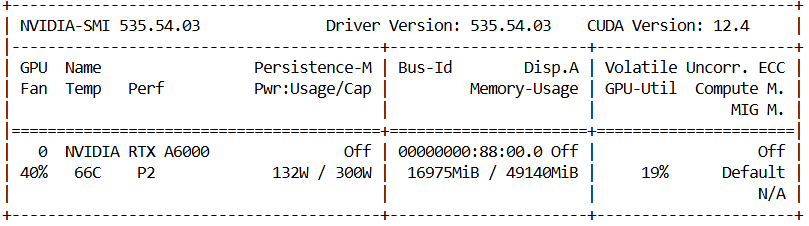

In [54]:
# Notice how many outputs looks the same - not a good sign?

for i, (key, value) in enumerate(outputs.items()):
    if i < 10: print(f"Key: {key}, Value: {value}")
    else: break

Key: CXR3030_IM-1405, Value: bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.
Key: CXR38_IM-1911, Value: bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.
Key: CXR3957_IM-2022, Value: bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.
Key: CXR621_IM-2203, Value: bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.
Key: CXR1347_IM-0225, Value: bone: No acute bony abnormalities. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contours are normal.
Key: CXR2915_IM-1317, Va

# Model Performance Evaluation

GREEN: Generative Radiology Report Evaluation and Error Notation. https://github.com/Stanford-AIMI/GREEN/tree/main

To install in Jupyter Labs, first, in terminal:
- make sure you have python >= 3.121 or install it
- python3.12 -m venv myenv3124     # create venv 
- source myenv3124/bin/activate    
- pip install ipykernel
- python3.12 -m ipykernel install --user --name=myenv3124 --display-name "myenv3124"
	

To install GREEN, first: 
- Python 3.12.1 (works on 3.12.4)
- pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu118

Then follow - https://github.com/Stanford-AIMI/GREEN/tree/main : 
- git clone https://github.com/Stanford-AIMI/GREEN.git
- cd GREEN
- pip install -e .

##  Test green_score

In [1]:
# You must have 3.12.1 or 3.12.4, or similar that works
import json
import sys
print(sys.executable)
from green_score import GREEN

/home/myenv3124/bin/python3.12


In [2]:
model_name = "StanfordAIMI/GREEN-RadLlama2-7b"
green_scorer = GREEN(model_name, output_dir=".")

/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Calculate green_score on true vs. inferred data

In [5]:
# Load Ground Truth reports

df_data = pd.read_pickle('data/df_data.pkl')

# Select test only and format to strings 
data_test  = df_data.loc[df_data['split'] == 'test',  :].copy()
data_test['report'] = data_test['report'].apply(lambda x: ' '.join([f"{k}: {v}" for k, v in x.items()]))
data_test

report split
id                                                                      
CXR3030_IM-1405  bone: No acute bony abnormality. heart: Normal...  test
CXR38_IM-1911    bone: Bony structures are intact. heart: The h...  test
...                                                            ...   ...
CXR2312_IM-0887  bone:  heart: The heart is normal in size. lun...  test
CXR49_IM-2110    bone: Degenerative changes of the thoracic spi...  test

[590 rows x 2 columns]

In [6]:
file_name = "Qwen2-VL-7B-Instruct-bnb-4bit_finetuned_xray_report_TEST_OUTPUT.json"

with open(file_name, "r") as file:
    outputs = json.load(file)    

df = pd.DataFrame.from_dict(outputs, orient='index', columns=['report_pred'])
data_test = pd.merge(data_test, df, left_index=True, right_index=True)

In [7]:
data_test

report split  \
CXR3030_IM-1405  bone: No acute bony abnormality. heart: Normal...  test   
CXR38_IM-1911    bone: Bony structures are intact. heart: The h...  test   
...                                                            ...   ...   
CXR2312_IM-0887  bone:  heart: The heart is normal in size. lun...  test   
CXR49_IM-2110    bone: Degenerative changes of the thoracic spi...  test   

                                                       report_pred  
CXR3030_IM-1405  bone: No acute bony abnormality. heart: Heart ...  
CXR38_IM-1911    bone: No acute bony abnormality. heart: Heart ...  
...                                                            ...  
CXR2312_IM-0887  bone: No acute bony abnormality. heart: Heart ...  
CXR49_IM-2110    bone: No acute bony abnormality. heart: Heart ...  

[590 rows x 3 columns]

In [8]:
green_scores = pd.DataFrame(index=data_test.index, columns=['mean', 'std'])

for idx, row in data_test.iterrows():
    try:
        mean, std, green_score_list, summary, result_df = green_scorer([row['report']], [row['report_pred']])
                
        green_scores.loc[idx, 'mean'] = mean
        green_scores.loc[idx, 'std'] = std
    except Exception as e:
        print(f"An error occurred at index {idx}: {e}")
        
        green_scores.loc[idx, 'mean'] = None
        green_scores.loc[idx, 'std'] = None

Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.14s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.146222114562988
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.12s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.122802257537842
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.18s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.86722731590271
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.82s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.878252744674683
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.13s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.889142513275146
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.795539855957031
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.36s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.668403387069702
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.93s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.192039251327515
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.27s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.796311378479004
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.73s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.40293264389038
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.68s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.145965099334717
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.58s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.58756422996521
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.33s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.365219831466675
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.71s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.840976238250732
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.73s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.24052095413208
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.39s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.162408590316772
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.34s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.993212938308716
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.054758548736572
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.71s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  15.713251113891602
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.80s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.585150480270386
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.90s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.486234426498413
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.88s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.346758604049683
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:17, 17.03s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  22.19447660446167
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.92s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  15.930105924606323
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:17, 17.87s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  17.87314009666443
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.40s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.07189416885376
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.30s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.303106784820557
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.11s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.805446147918701
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.468350887298584
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.82s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.783026695251465
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.900497436523438
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.95s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.467562437057495
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.53s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.253005504608154
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.37s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.379534244537354
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.85s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.333556890487671
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.21s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.729667901992798
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.29s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.291227579116821
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.19s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.19775390625
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.94s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.694042444229126
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.80s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.808715581893921
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.19s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.324522972106934
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.50s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.699334144592285
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.87s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.452990770339966
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.09s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.011844396591187
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.10s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.060269594192505
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.62s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.181580066680908
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.52s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.324100732803345
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.79s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.284188985824585
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.68s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.70238709449768
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.87s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.91021180152893
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.31s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.4866464138031
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.37s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.55799150466919
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.37s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.990747451782227
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.81s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.812377691268921
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.17s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.806942462921143
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.19s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.197595357894897
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.63s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.151135206222534
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.25s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.20484185218811
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.48s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.487873077392578
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.44s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.347829341888428
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.71s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.052781105041504
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.81s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.811393737792969
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.91s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.9124116897583
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.28s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.195940732955933
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.51s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.518754720687866
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.68s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.68663763999939
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.39s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.65061354637146
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.76s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.38513445854187
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.38s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.422449588775635
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.99s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.99855089187622
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.67s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.97120714187622
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.07s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  16.074195623397827
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.93s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.197479486465454
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.00s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.92015552520752
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.622029066085815
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.94s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  15.94599199295044
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.78s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.783946752548218
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.61s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.734373569488525
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.77s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.632812023162842
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.74s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.636577367782593
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.68s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  16.68909502029419
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.98s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.442599534988403
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.67s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.817681074142456
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.87s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.358328104019165
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.53s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.540431499481201
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.04s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.705693244934082
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.16s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.199999809265137
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.70s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.729757308959961
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.08s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.063056468963623
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.02s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.837885618209839
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.09s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.095849752426147
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.34s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  16.34518027305603
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.62s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.121307373046875
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.23s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.711247444152832
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.31s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.315369606018066
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.12s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.281237363815308
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.63s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.637060642242432
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.52s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.52350640296936
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.72s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.730660438537598
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.23s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.416810989379883
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.18s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.79617190361023
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.65s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.658057451248169
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.44s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.69792103767395
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.74s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.2091827392578125
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.74s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.746312856674194
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.77s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.773286581039429
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.65s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.359946966171265
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.40s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.409196853637695
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.28s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.502982139587402
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.84s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.842307329177856
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.38s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.390655994415283
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.68s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.045515775680542
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.67s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.687892436981201
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.68s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.328529357910156
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.52s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.202852487564087
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.99s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.000694274902344
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.57s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.76495885848999
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.82s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.320473432540894
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.55s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.62474036216736
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.74s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.15288519859314
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.27s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.212697505950928
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.11s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.634644985198975
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.64s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.390705585479736
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.77s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.417170286178589
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.77s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.77898645401001
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.54s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.787338733673096
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 13.00s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.005125522613525
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.05s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.599371910095215
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.36s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.48777484893799
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.80s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.806578636169434
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.78s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.797862768173218
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.18s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.185070514678955
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.34s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.9716637134552
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.95s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.4322190284729
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.50s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.122604608535767
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.66s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.042744636535645
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.75s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.730005264282227
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.03s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.587733507156372
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.75s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.846248149871826
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.664252519607544
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.75s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.890027523040771
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.09s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.094316482543945
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.42s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.98479175567627
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.04s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.050248384475708
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.43s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.432109117507935
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.31438684463501
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.59s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.285572528839111
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.48s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.488527297973633
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 14.00s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.003341436386108
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.42s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.9350059032440186
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.85s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.71743392944336
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.71s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.912315845489502
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.40s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.996214628219604
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.55s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.095911026000977
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.46s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.471341848373413
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.37s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.504932641983032
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.70s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.212437629699707
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.58s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.545487880706787
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.461099624633789
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.92s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.927409410476685
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.71s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.365817308425903
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.49s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.916357517242432
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.57s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.076349258422852
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.26s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.267738342285156
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.26s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.279090881347656
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.67s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.671361207962036
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.19s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.786638021469116
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.41s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.42045283317566
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.37s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.244363069534302
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.06s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.515753507614136
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.43s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.575124263763428
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.05s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.49280071258545
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.22s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.752850770950317
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.65s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.660373449325562
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.63s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.476313352584839
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.23s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.233092069625854
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.57s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.55596923828125
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.49s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.437077283859253
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.04s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.04825496673584
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.30s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.39559268951416
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 13.00s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.005924701690674
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.62s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.23020315170288
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.84s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.843810319900513
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.67s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.19634222984314
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.21s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.189828634262085
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.68s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.606191635131836
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.33245873451233
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.49s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.51751947402954
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.00s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.32015562057495
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.97s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.622103214263916
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.77s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.295072078704834
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.23s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.91002631187439
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.72s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.15440058708191
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.34s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.538962841033936
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.53s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.298349380493164
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.75s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.753826379776001
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.64s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.770815134048462
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.36s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.7737557888031
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.19s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.189806461334229
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.95s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.953051805496216
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.90s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.032060384750366
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.58s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.495277404785156
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.84s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  23.866782426834106
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.89s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.752737998962402
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.43s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.995206117630005
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.34s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.084722995758057
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.78s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.112394571304321
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.60s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.245686531066895
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.20s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.336223363876343
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.69s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.6972815990448
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.53s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.679659843444824
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.30s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.195437908172607
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.16s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.498984336853027
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.57s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.990761280059814
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.06s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.237748622894287
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.26s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.74954628944397
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.85s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.854121208190918
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.25s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.837220191955566
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.26s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.162834167480469
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.80s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.808155059814453
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.38s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.738150358200073
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.19s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.198856830596924
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.18s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.516765117645264
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.21s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.560577392578125
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.41s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.35460352897644
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.78s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.789461612701416
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.96s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.07350993156433
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.68s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.189203023910522
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.73s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.199875593185425
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.42s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.962913513183594
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.76s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.191126823425293
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.56s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.160249948501587
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.27s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.267911672592163
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.88s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.380719900131226
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.24s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.173037767410278
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.38s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.06122660636902
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.58s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.667185544967651
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.11s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.087117910385132
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.19s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.219558000564575
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.51s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.418717384338379
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.02s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.026827335357666
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.33s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.336946487426758
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.323121547698975
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.17s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.120208501815796
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.66s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.74930214881897
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.47s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.650024890899658
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.86s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.783915281295776
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.13s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.888751029968262
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.36s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.481074333190918
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.29s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.57952117919922
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.44s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and wi

Seconds per example:  25.51749038696289
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.00s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.161805391311646
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.73s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.65787386894226
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.20s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.640827894210815
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.19s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.668856143951416
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.07s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.78987169265747
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.97s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.293375492095947
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.01s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.543586015701294
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.23s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.87056565284729
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.80s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.240814685821533
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.41s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.907222270965576
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.04s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.9955096244812
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.04s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.08959984779358
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.51s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.031610250473022
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.66s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.829704999923706
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.26s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.718519687652588
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.59s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.113786220550537
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.93s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.932876110076904
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.49027967453003
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.448954343795776
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.86s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.392444610595703
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.77s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.779443502426147
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.94s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.295803785324097
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.88s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.4104323387146
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.96s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.964989423751831
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.82s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.82536244392395
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.87s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.99141812324524
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.01s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.484670877456665
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.04s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.55356764793396
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.89s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.99830412864685
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.64s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.197359323501587
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.71s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.74968433380127
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.94s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.18329095840454
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.32s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.35779070854187
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.43s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.853911399841309
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:17, 17.58s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  17.58666491508484
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.87s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.525934934616089
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.65s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.6200270652771
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.06s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.11464500427246
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.78s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.876579999923706
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.85s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.856436729431152
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.20s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.207878112792969
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.66s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.666322231292725
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.08s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.721614360809326
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.61s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.213773012161255
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.66s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.617235660552979
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.50s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.078394412994385
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.84s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.602368593215942
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.82s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.13470435142517
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.72s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.239012956619263
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.96s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.948991060256958
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.54s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.210190534591675
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.46s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.7639901638031
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.73s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.30078649520874
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.56s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.350082397460938
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.95s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.474304914474487
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.79s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.8319833278656
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.78s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.447735071182251
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.32s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.047532320022583
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.93s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.419512510299683
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.60s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.705495119094849
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.45s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.55574893951416
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.74s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.746551752090454
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.13s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.769121885299683
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.54s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.602957248687744
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.520659685134888
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.70s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.819813013076782
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.47s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.31273365020752
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.98s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.244290351867676
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.67s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.67168116569519
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.49s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.271944284439087
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.41s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.137165069580078
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.60s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.520104885101318
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.30s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.37972593307495
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.098032712936401
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.07s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.07670283317566
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.00s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.320362329483032
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.72s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.497564554214478
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.66s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.662551403045654
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.49s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.791722774505615
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.64s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.065054655075073
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.58s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.248959302902222
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.72s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.721653461456299
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.55s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.559252500534058
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.56s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.04567003250122
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.46s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.367464065551758
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.21s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.397271633148193
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.87s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.550657987594604
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.12s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.705954790115356
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.75256037712097
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.49s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.790003538131714
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.14s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  16.14795231819153
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.05s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.546817302703857
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.62s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.051367044448853
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.30s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.79961347579956
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.77s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  15.779960632324219
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.04s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.84824848175049
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.70s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.701817035675049
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.64s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.192398071289062
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.04s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.895840883255005
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:17, 17.52s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  25.817642211914062
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.53s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.459429502487183
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.086539030075073
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.96s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.591737747192383
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.34s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.34327220916748
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.85s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.857623100280762
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.24s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.875248432159424
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.75s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.356191635131836
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.38s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  6.956784963607788
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.46s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.84502363204956
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.17s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.02886700630188
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.15s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.83486819267273
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.87s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.876028060913086
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.21s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.769205093383789
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.58s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.876160383224487
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.96s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.800276517868042
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.09s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.46414041519165
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.45s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.458281755447388
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.52s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.10552167892456
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.52s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.816361665725708
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.04s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.043779850006104
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.83s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.834535121917725
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.37s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.88813328742981
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.04s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.164519548416138
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.30s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.304324865341187
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.85s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.977418422698975
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.46s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.258764266967773
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.83s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.362549304962158
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.98s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.062323808670044
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.20s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.737135887145996
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.51s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.062265634536743
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.88s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.358145713806152
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.09s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.098301649093628
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.20s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.42590856552124
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.07s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.198355197906494
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.94s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.457882642745972
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.14s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.336556673049927
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.04s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.047168493270874
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.02s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.926371097564697
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.602009296417236
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.70s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.705941915512085
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.41s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.661983013153076
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.81s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.432802200317383
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.58s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.59066653251648
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.85s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.42396092414856
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.47s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.978293657302856
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.382398128509521
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.09s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.788465738296509
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.262609004974365
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.45s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.857809066772461
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.22s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.230523586273193
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.04s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.38373589515686
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.15s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.202018976211548
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.96s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.510833978652954
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.19s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.333372831344604
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.94s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.94500207901001
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.784280776977539
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.57s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.578001260757446
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.28s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.670917510986328
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.93s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.648799419403076
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.81s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.284851789474487
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.94s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.94284439086914
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.47s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.529399871826172
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.14s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.778229713439941
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.94s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.7491984367370605
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.73s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.731613159179688
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.34s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.80797052383423
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.21s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.655766725540161
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.666967153549194
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.84s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.850984811782837
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.73s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.601035356521606
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.13s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.707340478897095
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.73s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.736314535140991
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.27s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.703076362609863
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.95s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.880668878555298
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.80s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.806560516357422
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.30s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.450464963912964
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.54s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.597575664520264
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.08s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.117892742156982
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.31s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.394651412963867
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.62s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.453322887420654
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.71s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.909252166748047
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.40s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.439281940460205
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.85s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.958455801010132
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.00s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.044375658035278
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.81s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.081664562225342
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.23s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.777140855789185
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.157682657241821
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.53s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.995665073394775
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.07s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.078654527664185
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.26s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.176157712936401
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.73s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and wi

Seconds per example:  23.370569467544556
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.15s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.634920358657837
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.81s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.755552530288696
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.940672636032104
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.32s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.326588153839111
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.13s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.05772614479065
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.50s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.989441871643066
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.46s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.677968502044678
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.94s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.951315879821777
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.07s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.076573371887207
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.63s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.964940309524536
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.10731291770935
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.640018224716187
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.28s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.769057989120483
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.99s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.991966247558594
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.62s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.151381015777588
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.33s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.20011591911316
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.38s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.827917575836182
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.29s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.755549430847168
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.75s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.755653619766235
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.62s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.127151250839233
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.93s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.520126819610596
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.871447324752808
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.11s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.115365743637085
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.86s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.424271821975708
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.02s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.033982038497925
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.25s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.356907606124878
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.07s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.710890769958496
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.01s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  15.461997985839844
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.87s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.331228256225586
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.20s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.72862434387207
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.40s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.492838621139526
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.93s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.298064708709717
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.80s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.838266134262085
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.37s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.822641611099243
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.45s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.945009469985962
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.39s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.830651998519897
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.93s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.886608600616455
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.35s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.823071718215942
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.36s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.36392068862915
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.579888820648193
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.42s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  14.38361668586731
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.31s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.757005214691162
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.13s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.134891986846924
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.51s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.477396011352539
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.63s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.116283416748047
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.895880460739136
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  6.00s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.431198358535767
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.89s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.355899810791016
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.75s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.421272277832031
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.01s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.010754108428955
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.40s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.403594732284546
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.74s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.751007080078125
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.51s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.021687269210815
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.81s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.355895757675171
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.37s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.896180152893066
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.02s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.121508836746216
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.22s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.469812870025635
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.39s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.398012638092041
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.71s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.300812482833862
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.99s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.357654571533203
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.47s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.6168372631073
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.66s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.292491912841797
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.51s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.014331817626953
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:19, 19.11s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  24.247555017471313
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.72s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.730346202850342
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.76s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.71618342399597
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.39s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.352041721343994
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.44s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.561243295669556
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.55s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.551659107208252
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:15, 15.91s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.919159650802612
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:18, 18.20s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  23.278958082199097
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.30s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.19851016998291
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.52s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.548680067062378
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:18, 18.16s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  23.595414876937866
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.39s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  24.19537329673767
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.75s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.752830266952515
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.03s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.01425862312317
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.02s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.02586030960083
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.57s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.04601788520813
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.94s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  23.639396905899048
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.63s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.564029693603516
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.92s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.368537664413452
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.31s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.837700843811035
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.32s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.64518427848816
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.40s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  16.326868772506714
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.61s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.736023664474487
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.84s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.863200426101685
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 11.13s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  11.132275104522705
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.70s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.240012645721436
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.57s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.68488621711731
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.944799184799194
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.14s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.643223524093628
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.780810117721558
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.86s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.861893892288208
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.76s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  10.768425941467285
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.18s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.668854236602783
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.98s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.940251111984253
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.05s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.909516096115112
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.53s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.663512468338013
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.48s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.523020267486572
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.80s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.137447595596313
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.64s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.178603649139404
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.99s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.623638153076172
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.57s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.638610124588013
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.95s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.58259129524231
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.13s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.148792266845703
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.93s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.859595775604248
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.52s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  21.761223554611206
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.54s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.539478063583374
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:04,  4.82s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  7.384851694107056
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.95s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.521993637084961
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.62s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.099310398101807
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.40s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.89476227760315
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.88s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.881278038024902
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.14s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.156445503234863
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.27s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.813117980957031
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.36s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.786519289016724
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.06s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  13.060915470123291
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.11s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.195453405380249
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.64s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.259760856628418
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:05,  5.79s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.331016302108765
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.83s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.435632705688477
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.76s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.785744190216064
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.50s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.680880308151245
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.30s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.670221328735352
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.36s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.01459264755249
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.79s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.7884840965271
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.69s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.861480712890625
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:16, 16.99s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  22.076865673065186
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:17, 17.39s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  24.868289709091187
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.90s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.901143074035645
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.39s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.401055097579956
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.35s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  8.807141780853271
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.42s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.31139063835144
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:09,  9.01s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  11.651406288146973
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:06,  6.45s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  12.882177591323853
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:13, 13.29s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.67775583267212
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.78s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.802733659744263
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.84s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  17.864814281463623
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.60s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.18894910812378
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:12, 12.60s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  20.162512063980103
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.57s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.060629606246948
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.10s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  14.104156494140625
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:17, 17.77s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  23.373113870620728
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:08,  8.25s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  10.836332082748413
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:07,  7.12s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.593677043914795
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:11, 12.00s/it]

==== End Inference ====
Computing summary ...
Seconds per example:  12.004910945892334
Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:14, 14.05s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  19.021450519561768


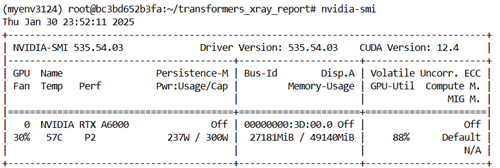

In [9]:
green_scores.to_csv('data/green_scores_Qwen2-VL-7B.csv', index=True)

In [10]:
green_scores

mean  std
CXR3030_IM-1405    1.0  0.0
CXR38_IM-1911      1.0  0.0
...                ...  ...
CXR2312_IM-0887    1.0  0.0
CXR49_IM-2110    0.375  0.0

[590 rows x 2 columns]

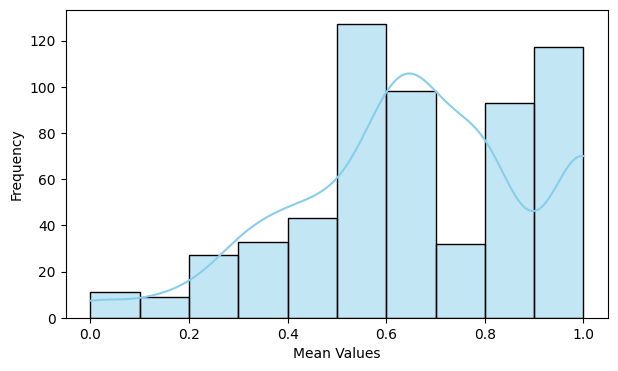

In [11]:
# Kernel Density Estimate plot

import seaborn as sns
plt.figure(figsize=(7, 4))
sns.histplot(green_scores['mean'], bins=10, kde=True, color='skyblue')
plt.xlabel('Mean Values'); plt.ylabel('Frequency');